In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Users/edgarguevara/Desktop/data_bootcamp/homework/sqlalchemy-challenge/SurfsUp/Resources/hawaii.sqlite")



In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found

base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement= base.classes.measurement

station= base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session= Session(engine )

# Exploratory Precipitation Analysis

In [10]:
from sqlalchemy import inspect

In [11]:
inspector= inspect(engine)

In [12]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])
print("----------------------station data:")
columns_station= inspector.get_columns('Station')
for column in columns_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------station data:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
most_recent_date= session.query(measurement.date).order_by(measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


In [14]:
import datetime as dt

2016-08-23


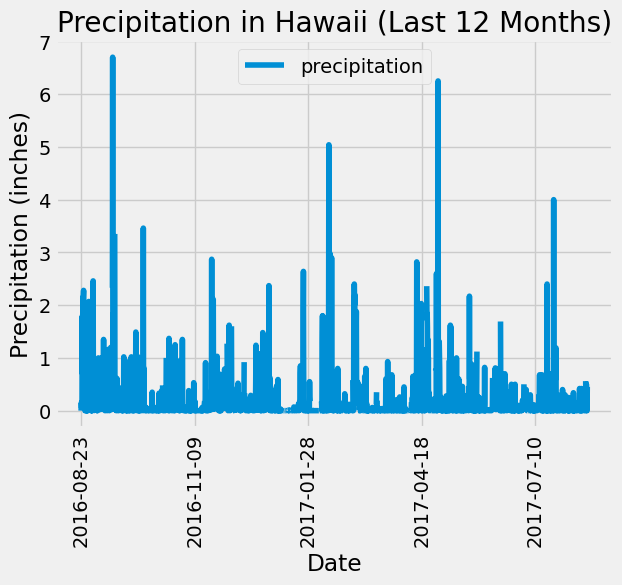

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date
# Calculate the date one year from the last date in data set.
one_year_ago= dt.date(2017, 8, 23)- dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
query= select([measurement.date, measurement.prcp]).where(measurement.date >= one_year_ago).order_by(measurement.date)
result= engine.execute(query).fetchall()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df= pd.DataFrame(result, columns= ['date', 'precipitation'])

# Sort the dataframe by date
df.set_index('date', inplace=True)
df= df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Hawaii (Last 12 Months)')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['precipitation'].describe()
print(precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
query= select([func.count(station.id)])
result= engine.execute(query).scalar()

print("There are " + str(result) + " stations in the dataset")

There are 9 stations in the dataset


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc())

results= query.all()

print("Most active stations:")
for station, count in results:
    print(f"Station {station}: {count} rows")


Most active stations:
Station USC00519281: 2772 rows
Station USC00519397: 2724 rows
Station USC00513117: 2709 rows
Station USC00519523: 2669 rows
Station USC00516128: 2612 rows
Station USC00514830: 2202 rows
Station USC00511918: 1979 rows
Station USC00517948: 1372 rows
Station USC00518838: 511 rows


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).first()[0]

lowest_temp= session.query(func.min(measurement.tobs)).filter(measurement.station== most_active_station).all()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station== most_active_station).all()
average_temp= session.query(func.avg(measurement.tobs)).filter(measurement.station== most_active_station).all()


print(f'The lowest temp of the most active station was {lowest_temp}')
print(f'The highest temp of the most active station was {highest_temp}')
print(f'The avg temp of the most active station was {average_temp}')


The lowest temp of the most active station was [(54.0,)]
The highest temp of the most active station was [(85.0,)]
The avg temp of the most active station was [(71.66378066378067,)]


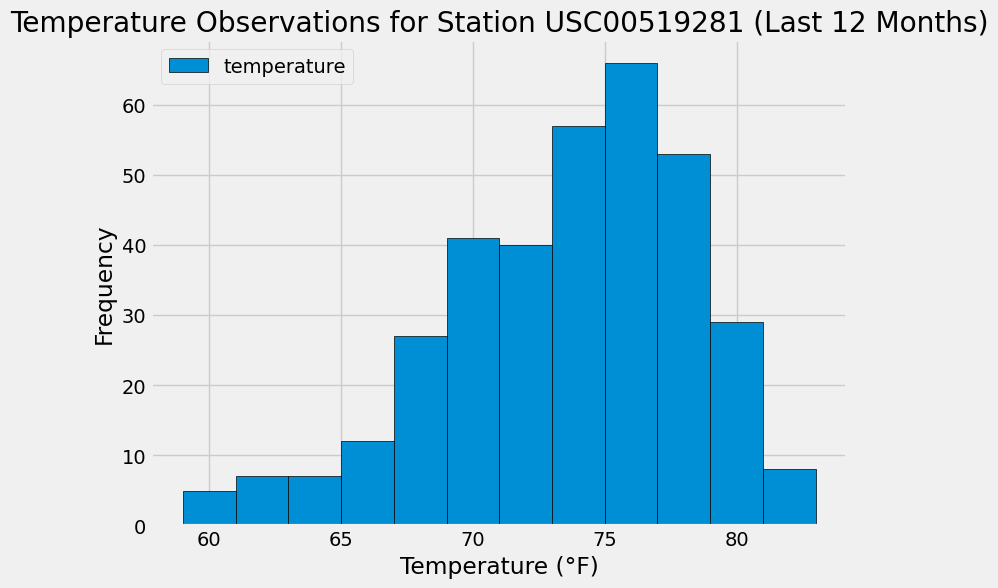

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs_last_12_months = session.query(measurement.date, measurement.tobs)\
                          .filter(measurement.station == most_active_station)\
                          .filter(measurement.date >= one_year_ago)\
                          .all()

temperature_observation_df = pd.DataFrame(temp_obs_last_12_months, columns=["date", "temperature"])
temperature_observation_df.set_index("date", inplace=True)
temperature_observation_df.sort_values(by="date", inplace=True)

temperature_observation_df.plot(kind="hist", bins=12, figsize=(8,6), edgecolor="black")

plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")

plt.show()



# Close Session

In [21]:
# Close Session
session.close()